In [27]:
def convert_fit_results(est_fn,
                        output_fn,
                        stim_width,
                        stim_height):
    """
    Convert pRF fitting value in different parameters for following analysis
   
    Parameters
    ----------
    est_fn: absolute paths to estimates file
    output_fn: absolute path to derivative file
    stim_width: stimulus width in deg
    stim_heigth: stimulus height in deg

    Returns
    -------
    prf_deriv: derivative of pRF analysis

    stucture output:
    columns: 1->size of input
    row00 : R2
    row01 : eccentricity in deg
    row02 : polar angle real component in deg
    row03 : polar angle imaginary component in deg
    row04 : size in deg
    row05 : amplitude
    row06 : baseline
    row07 : coverage
    row08 : x
    row09 : y
    ['prf_rsq','prf_ecc','prf_polar_real','prf_polar_imag','prf_size','prf_amp','prf_baseline','prf_cov','prf_x','prf_y']
    """

    # Imports
    # -------
    # General imports
    import os
    import nibabel as nb
    import glob
    import numpy as np
    import ipdb
    deb = ipdb.set_trace
    
    # Popeye imports
    from popeye.spinach import generate_og_receptive_fields

    # Get data details
    # ----------------
    est = []
    img_est = nb.load(est_fn)
    est = img_est.get_fdata()

    # Compute derived measures from prfs
    # ----------------------------------
    # get data index
    x_idx, y_idx, sigma_idx, beta_idx, baseline_idx, rsq_idx = 0, 1, 2, 3, 4, 5

    # change to nan empty voxels
    est[est[:,:,:,rsq_idx] == 0] = np.nan
    
    # r-square
    prf_rsq = est[:,:,:,rsq_idx]

    # pRF eccentricity
    prf_ecc = np.nan_to_num(np.sqrt(est[:,:,:,x_idx]**2 + est[:,:,:,y_idx]**2))

    # pRF polar angle
    complex_polar = est[:,:,:,x_idx] + 1j * est[:,:,:,y_idx]
    normed_polar = complex_polar / np.abs(complex_polar)
    prf_polar_real = np.real(normed_polar)
    prf_polar_imag = np.imag(normed_polar)
    
    # pRF size
    prf_size = est[:,:,:,sigma_idx].astype(np.float64)
    prf_size[prf_size<1e-4] = 1e-4

    # pRF amplitude
    prf_amp = est[:,:,:,beta_idx]
    
    
    # pRF baseline
    prf_baseline = est[:,:,:,baseline_idx]

    # pRF coverage
    deg_x, deg_y = np.meshgrid(np.linspace(-30, 30, 10), np.linspace(-30, 30, 10))         # define prfs in visual space
    flat_est = est.reshape((-1, est.shape[-1])).astype(np.float64)
    rfs = generate_og_receptive_fields( flat_est[:,x_idx],
                                        flat_est[:,y_idx],
                                        flat_est[:,sigma_idx],
                                        flat_est[:,beta_idx].T*0+1,
                                        deg_x,
                                        deg_y)

    total_prf_content = rfs.reshape((-1, flat_est.shape[0])).sum(axis=0)
    log_x = np.logical_and(deg_x >= -stim_width/2.0, deg_x <= stim_width/2.0)
    log_y = np.logical_and(deg_y >= -stim_height/2.0, deg_y <= stim_height/2.0)
    stim_vignet = np.logical_and(log_x,log_y)
    prf_cov = rfs[stim_vignet, :].sum(axis=0) / total_prf_content
    prf_cov = prf_cov.reshape(prf_baseline.shape)
    
    # pRF x
    prf_x = est[:,:,:,x_idx]

    # pRF y
    prf_y = est[:,:,:,y_idx]

    # Save results
    prf_deriv = np.zeros((est.shape[0],est.shape[1],est.shape[2],10))*np.nan
    prf_deriv[...,0]  = prf_rsq
    prf_deriv[...,1]  = prf_ecc
    prf_deriv[...,2]  = prf_polar_real
    prf_deriv[...,3]  = prf_polar_imag
    prf_deriv[...,4]  = prf_size
    prf_deriv[...,5]  = prf_amp
    prf_deriv[...,6]  = prf_baseline
    prf_deriv[...,7]  = prf_cov
    prf_deriv[...,8]  = prf_x
    prf_deriv[...,9]  = prf_y
        
#     prf_deriv = prf_deriv.astype(np.float32)
#     new_img = nb.Nifti1Image(dataobj = prf_deriv, affine = img_est.affine, header = img_est.header)
#     new_img.to_filename(output_fn)

    return prf_amp, prf_size

In [28]:
# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import json
import glob
import numpy as np
import ipdb
import platform
opj = os.path.join
deb = ipdb.set_trace

# MRI imports
# -----------
import nibabel as nb
import cortex
from cortex.fmriprep import *
from nilearn import image

# Get inputs
# ----------
subject = 'sub-001'
task = 'GazeCenterFS'
preproc = 'fmriprep_dct'

# Define analysis parameters
# --------------------------
with open('../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define folder
# -------------
base_dir = analysis_info['base_dir']
deriv_dir = opj(base_dir,'pp_data',subject,'gauss','deriv')


# Open estimates data

# Save estimates data
estfn = "{base_dir}/pp_data/{subject}/gauss/fit/{subject}_task-{task}_{preproc}_avg_est.nii.gz".format(
                                base_dir = base_dir,
                                subject = subject,
                                task = task,
                                preproc = preproc)

# Compute derived measures from prfs
# ----------------------------------
print('extracting pRF derivatives')
outfn = "{base_dir}/pp_data/{subject}/gauss/fit/{subject}_task-{task}_{preproc}_deriv.nii.gz".format(
                                base_dir = base_dir,
                                subject = subject,
                                task = task,
                                preproc = preproc)

prf_amp, prf_size = convert_fit_results(est_fn = estfn,
                    output_fn = outfn,
                    stim_width = analysis_info['stim_width'],
                    stim_height = analysis_info['stim_height'])

extracting pRF derivatives


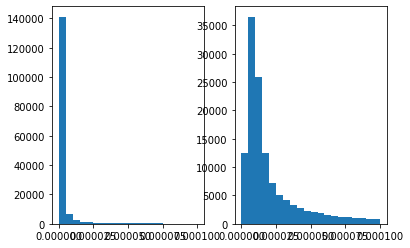

In [37]:
import matplotlib.pyplot as plt
n_bins = 20
range_val = (0,0.0001)
fig, axs = plt.subplots(1, 2)
val0 = prf_amp.reshape(-1)
val1 = val0*(2*np.pi*prf_size.reshape(-1)**2)
axs[0].hist(val0, bins=n_bins,range=range_val);
axs[1].hist(val1, bins=n_bins,range=range_val);